In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss

In [3]:
members = pd.read_csv(r'E:\KKbox\members_v3.csv')
members =members.loc[(members['bd']>2) & (members['bd']<99)]
train = pd.read_csv(r'E:\KKbox\train.csv')
df = pd.merge(members,train,how='inner',on=['msno'])
df = df.iloc[0:50000]
msnos = df['msno']
relevant_user_logs = pd.read_csv(r'E:\KKbox\feb_user_logs.csv')
#relevant_transactions = pd.read_csv(r'C:\Users\liamc\OneDrive\Desktop\Data Science\KKbox\relevant_transactions.csv')                                 

In [4]:
df['registration_init_time'] = pd.to_datetime(df['registration_init_time'],format='%Y%m%d')

In [5]:
mean_user_logs = pd.DataFrame(index=[],columns=[])

In [6]:
mean_user_logs['num_25'] = relevant_user_logs.groupby('msno')['num_25'].mean()
mean_user_logs['num_50'] = relevant_user_logs.groupby('msno')['num_50'].mean()
mean_user_logs['num_75'] = relevant_user_logs.groupby('msno')['num_75'].mean()
mean_user_logs['num_985'] = relevant_user_logs.groupby('msno')['num_50'].mean()
mean_user_logs['num_100'] = relevant_user_logs.groupby('msno')['num_100'].mean()
mean_user_logs['num_unq'] = relevant_user_logs.groupby('msno')['num_unq'].mean()
mean_user_logs['total_secs'] = relevant_user_logs.groupby('msno')['total_secs'].mean()
mean_user_logs['days_logged'] = relevant_user_logs.groupby('msno')['date'].count()

In [7]:
mean_user_logs = mean_user_logs.reset_index()

In [8]:
df = pd.merge(df,mean_user_logs,how='inner',on='msno')

In [9]:
end_day = datetime.date(2017,3,1)
df['days_since_registered'] = end_day - df['registration_init_time']
df['days_since_registered'] = df['days_since_registered'].dt.days

In [10]:
df = pd.get_dummies(df,columns=['city','registered_via','gender'])

In [11]:
df.head()

,msno,bd,registration_init_time,is_churn,num_25,num_50,num_75,num_985,num_100,num_unq,...,city_20,city_21,city_22,registered_via_3,registered_via_4,registered_via_7,registered_via_9,registered_via_13,gender_female,gender_male
0,tlGR5F/+vDFsnQme+KnvXKsCh3y31I1/dBaGuHDfdII=,39,2011-10-12,0,0.0,0.0,0.0,0.0,12.0,5.0,...,0,0,0,0,0,1,0,0,1,0
1,m0h0+lJIok7k6BzAoOnq+x+mB1tbi9shGF/egYLbed4=,22,2014-10-20,0,27.4,4.6,1.4,4.6,28.6,50.8,...,0,0,0,0,0,1,0,0,1,0
2,eIOUZ5I+NV/3EDfn/U/tMepn4FJt2SdzOrWGH1tNlYI=,24,2014-10-25,0,1.5,1.5,0.5,1.5,5.5,6.5,...,0,0,0,1,0,0,0,0,0,1
3,0uAjNEzX6IY+lZ+PYv9W31mZjHxUWkbFz9LL8m9G46k=,23,2014-11-03,0,9.0,2.0,2.2,2.0,79.2,66.6,...,0,0,0,0,0,1,0,0,1,0
4,gSQhnGXJqBkTEdLKfQWiMHRwbHnpgLFirbSZbL6EyeE=,32,2014-11-03,0,15.2,3.4,2.4,3.4,43.4,43.6,...,0,0,0,1,0,0,0,0,0,1


In [12]:
y = df['is_churn'].values
X = df.drop(['is_churn','registration_init_time','msno'],axis=1).values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3)

In [24]:
knn = KNeighborsClassifier(n_neighbors=12)

In [25]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=12, p=2,
           weights='uniform')

In [26]:
y_pred = knn.predict(X_test)

In [27]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[5349    0]
 [ 334    0]]
             precision    recall  f1-score   support

          0       0.94      1.00      0.97      5349
          1       0.00      0.00      0.00       334

avg / total       0.89      0.94      0.91      5683



C:\Users\liamc\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


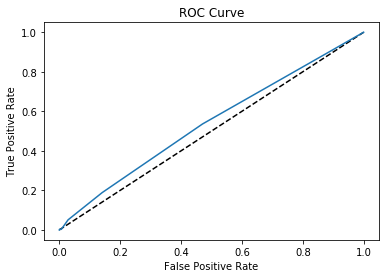

In [28]:
y_pred_prob = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [29]:
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
cv_auc = cross_val_score(knn,X,y,cv=5,scoring='roc_auc')
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.5400911581212225
AUC scores computed using 5-fold cross-validation: [0.55324398 0.49922321 0.52949332 0.5144449  0.52650304]


In [20]:
k_range = range(1, 31)
param_grid = {'n_neighbors':k_range}
knn_cv = GridSearchCV(knn, param_grid, cv=5,scoring='accuracy')
knn_cv.fit(X,y)
print("Tuned Logistic Regression Parameters: {}".format(knn_cv.best_params_)) 
print("Best score is {}".format(knn_cv.best_score_))

Tuned Logistic Regression Parameters: {'n_neighbors': 12}
Best score is 0.9430924352003378


In [30]:
log_loss(y_test,y_pred_prob)

1.0661409697052073